In [1]:
import torch
import numpy as np
import  matplotlib.pyplot as plt

In [2]:
import sys
import struct
import numpy as np
import sklearn
from sklearn import preprocessing
def readChoirData(dir,data_path, data_type):

    filename = dir + data_path + "_" + data_type + ".choir_dat"
    param = dict()

    with open(filename, 'rb') as f:
        nFeatures = struct.unpack('i', f.read(4))[0]
        nClasses = struct.unpack('i', f.read(4))[0]
        X = []
        y = []
        while True:
            newDP = []
            for i in range(nFeatures):
                v_in_bytes = f.read(4)
                if v_in_bytes is None or len(v_in_bytes) == 0:
                    # TODO very unprofessionally normalizing data
                    X = preprocessing.normalize(np.asarray(X), norm='l2')
                    param["nFeatures"], param["nClasses"], param["data"], param["labels"] = \
                        nFeatures, nClasses, X, np.asarray(y)
                    return param
                v = struct.unpack('f', v_in_bytes)[0]
                newDP.append(v)
            l = struct.unpack('i', f.read(4))[0]
            X.append(newDP)
            y.append(l)

In [3]:
train_data  = readChoirData('../isolet/','isolet', 'train')
test_data= readChoirData('../isolet/','isolet', 'test')

In [4]:
mapping_by_bit = {
    1: [0.01258386, 6.48191174],
    2: [0.01258386, 0.93122196, 3.29227301, 6.48191174],
    3: [0.01258386, 0.19029319, 0.69736032, 1.48546665, 2.50629356, 3.71152245, 5.05283471, 6.48191174],
    4: [0.01258386, 0.05145483, 0.16766473, 0.35630295, 0.61245889, 0.93122196, 1.30768154, 1.73692704, 2.21404785, 2.73413338, 3.29227301, 3.88355615, 4.5030722, 5.14591054, 5.80716059, 6.48191174],
}

In [33]:
class Quant_HDC_Model ( object ) :
    '''Hyperdimensional classification module . Arguments :
        * dimension ( int , > 0) : The dimensionality of the high dimensional representation .
        * classes ( int , > 0) : The number of classes of the problem .
        * input_features ( int , > 0) : Dimensionality of original data .
        * probability_distribution ( string ) : Probability distribution being used .←-
            For now , it can be Uniform , Gaussian , or Laplacian .
        * act_func ( string ) : Activation function being used . For now , it can be ←-
            tanh , sin cos , or None 
        * bits (int >) : n-bit precision for quantization.
    '''
    def __init__ (self, classes: int, input_features: int , probability_distribution : str, bits:int , act_func:str, dimension= 4000):
        self.classes = classes
        self.input_features = input_features
        self.dimension = dimension
        self.probability_distribution = probability_distribution
        self.act_func = act_func
        self.basis = self.generate_basis()
        self.class_hypervector = torch.zeros((classes,dimension))
        self.bits = bits
        self.cos = torch.nn.CosineSimilarity()
        self.std=[]
        # these variables are for drawing plot
        self.full_train_acc= []
        self.full_test_acc= []
        self.quant_train_acc = []
        self.quant_test_acc = [] 
        
    def generate_basis(self):
        size = (self.input_features,self.dimension)
        if self.probability_distribution == 'Uniform':
            return torch.empty(size).uniform_(-1,1)
    
        elif self.probability_distribution == 'Gaussian':
            return np.random.normal(0,1,size)
        
        elif self.probability_distribution == 'Laplacian':
             return np.random.laplace(0,1,size=size)
        else:
            raise "Probability distribution error"
    
    def encode(self, input: torch.Tensor):
        matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(self.basis,dtype=float))
        if self.act_func == 'tanh':
            return torch.tanh(matmul_result)
        elif self.act_func == 'sin cos':
            return torch.sin(matmul_result) * torch.cos(matmul_result)
        else:
            return matmul_result
    
    def train(self,train_data):
        for x,y in zip(train_data['data'],train_data['labels']):
            self.class_hypervector[y] += self.encode(torch.Tensor(x))
        
        #density function based spliting at first epoch only
        # Get values (ex) 0, 25, 50, 100 percetile values if 2bits)
        if len(self.std) ==  0:
            # normalization 
            class_hypervector = self.class_hypervector
            for c in range(self.classes):
                class_hypervector[c] /= np.linalg.norm(self.class_hypervector[c])
            feature_vec = np.sort(class_hypervector.flatten())
            for i in range(2** self.bits):
                self.std.append(feature_vec[int(feature_vec.shape[0] * i * 1/(2**self.bits))])
                
    #retraining full-precision model 
    def retrain(self,train_data):
        for x,y in zip(train_data['data'],train_data['labels']):
            pred = self.predict_full(x)
            if pred ==y:
                pass
            else:
                hv = self.encode(x)
                self.class_hypervector[pred] -= 0.01 * hv
                self.class_hypervector[y] += 0.01*  hv
                
    def quantize_train(self):
        # normalization 
        class_hypervector = self.class_hypervector.clone().detach()
        for c in range(self.classes):
            class_hypervector[c] /= np.linalg.norm(self.class_hypervector[c])
            
        # quantizing the trained hypervector 
        quant_train = np.zeros(self.class_hypervector.shape)
        for i in range((2**self.bits)-1):
            quant_train[(class_hypervector >=  self.std[i]) & (class_hypervector < self.std[i+1])] = i
        quant_train[(class_hypervector >=  self.std[i+1])] = i+1
        self.quant_train = quant_train
    
    def quantize_vector(self,hypervec):
        hypervec /= np.linalg.norm(hypervec)
        quantvec = np.zeros(hypervec.shape)
        for i in range((2**self.bits)-1):
            quantvec[(hypervec >=  self.std[i]) & (hypervec < self.std[i+1])] = i
        quantvec[(hypervec >=  self.std[i+1])] = i+1
        return quantvec
    
    def predict(self,quant_hv):
        return np.argmin(np.sum(np.vectorize(lambda x : mapping_by_bit[self.bits][int(x)])(np.absolute(np.subtract(self.quant_train,quant_hv))),axis=1))

    def predict_full(self,data:torch.Tensor):
        given_d = self.encode(data)
        return np.argmax(self.cos(self.class_hypervector,given_d))
        
    def test_quant(self,test_data):
        corr = 0
        for x, y in zip(test_data['data'],test_data['labels']):
            test_hv = self.encode(x)
            quant_hv = self.quantize_vector(test_hv)
            pred = self.predict(quant_hv)
            if pred == y:
                corr += 1 
        return corr

    def test_full(self,test_data):
        corr = 0
        for x, y in zip(test_data['data'],test_data['labels']):
            pred = self.predict_full(x)
            if pred == y:
                corr += 1 
        return corr
            
    def quant_iter_train(self,train_data,test_data,ax, epoch=1): 
        self.train(train_data)
        for i in range(epoch):
            print(f"======epoch: {i}")
            if epoch > 0: 
                self.retrain(train_data)
            self.quantize_train()
            
            # store model accuracy 
            self.full_train_acc.append(self.test_full(train_data)/train_data['data'].shape[0])
            self.full_test_acc.append(self.test_full(test_data)/test_data['data'].shape[0])       
            self.quant_train_acc.append( self.test_quant(train_data)/train_data['data'].shape[0])
            self.quant_test_acc.append(self.test_quant(test_data)/test_data['data'].shape[0])
            
            # quantization model validation and model update
            for x, y in zip(test_data['data'],test_data['labels']):
                valid_hv = self.encode(x)
                quant_hv = self.quantize_vector(valid_hv)
                pred = self.predict(quant_hv) 
                if pred == y:
                    pass
                else:
                    self.class_hypervector[pred] -= 0.01* valid_hv # update full-precision model 
                    self.class_hypervector[y] += 0.01* valid_hv # update full-precision model
        self.draw_acc_plot(epoch,ax)
        
    def draw_acc_plot(self,epoch, ax):
        x = range(1,epoch+1)
        ax.plot(x,self.full_train_acc,'bo-',label='full_train')
        ax.plot(x,self.full_test_acc,'bo--',label='full_test')
        ax.plot(x,self.quant_train_acc,'go-',label='quant_train')
        ax.plot(x,self.quant_test_acc,'go--',label='quant_test')
        ax.set_ylim(0.8,1.0)
        ax.legend(loc='best')

/var/folders/7b/5019l7l91yx79z61_pkr9gsm0000gn/T/ipykernel_3489/4070272698.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(self.basis,dtype=float))


======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 5
======epoch: 6
======epoch: 7
======epoch: 8
======epoch: 9
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 5
======epoch: 6
======epoch: 7
======epoch: 8
======epoch: 9
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 5
======epoch: 6
======epoch: 7
======epoch: 8
======epoch: 9
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 5
======epoch: 6
======epoch: 7
======epoch: 8
======epoch: 9


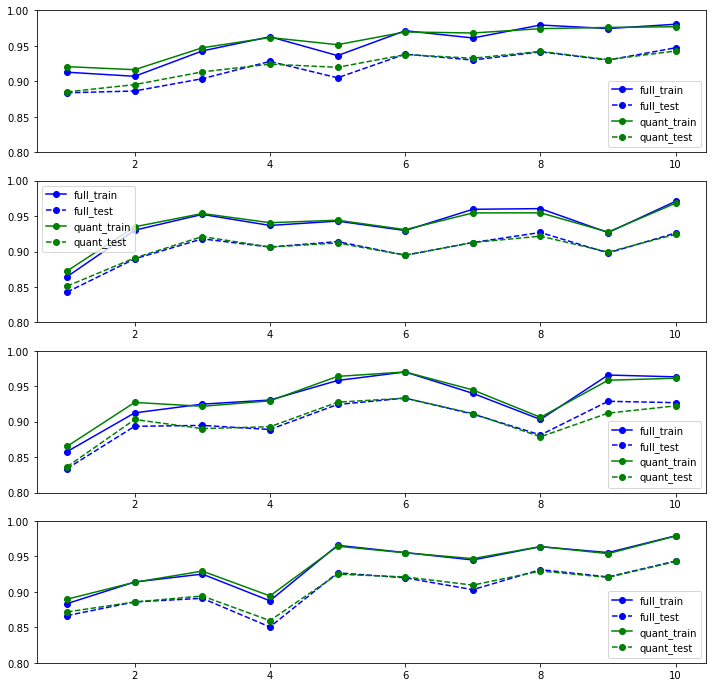

In [35]:
p = 'Uniform'
a = 'tanh'
b = 4 # 4-bit quantization
epoch = 10
fig, ax = plt.subplots(4, 1,figsize=(12,12))

for i, d in enumerate([512,2048,4096, 10000]):
    hdc = Quant_HDC_Model(train_data['nClasses'],train_data['nFeatures'], probability_distribution=p,act_func=a,dimension=d,bits=b)
    hdc.quant_iter_train(train_data,test_data,ax[i], epoch)
plt.show()

/var/folders/7b/5019l7l91yx79z61_pkr9gsm0000gn/T/ipykernel_18954/1721489136.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matmul_result = torch.matmul(torch.tensor(input,dtype=float), torch.tensor(self.basis,dtype=float))


======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4
======epoch: 0
======epoch: 1
======epoch: 2
======epoch: 3
======epoch: 4


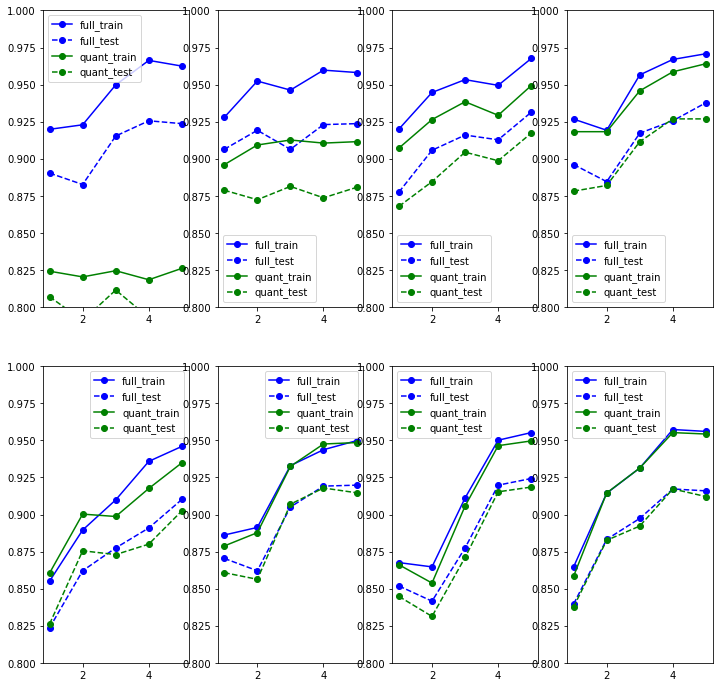

In [32]:
epoch = 5
fig, ax = plt.subplots(2, 4,figsize=(14,14))

for i, d in enumerate([512, 10000]):
    for b in range(1,5):
        hdc = Quant_HDC_Model(train_data['nClasses'],train_data['nFeatures'], probability_distribution=p,act_func=a,dimension=d,bits=b)
        hdc.quant_iter_train(train_data,test_data,ax[i][b-1], epoch)